✅ 현재 Revenue 모델 기준 정리

모델: XGBoost Regressor

목적: 매출(TotalCharges) 예측 → 고객 Lifetime Value 추정

전처리: 숫자 변수는 그대로, 범주형 변수는 OneHotEncoding

성능: R² ≈ 0.99, RMSE ≈ 80 ~ 100 → 매우 높은 정확도

Feature Importance:

tenure, MonthlyCharges → 매출 대부분 설명 (Baseline 역할)

계약/결제/서비스 관련 변수들 → 오차 보정(Residual 역할)  --> xgb안에 다 있음 residual 계산이

👉 그래서 발표하실 때는 이렇게 말씀하시면 됩니다:

“Revenue 예측은 XGBoost 모델을 사용했습니다.
매출은 본질적으로 가입 기간과 월 요금으로 설명되지만,
계약 유형, 결제 방식, 서비스 사용 여부 같은 요인이 오차를 보정해주면서 예측을 더욱 정교하게 만듭니다.
최종적으로 모델은 R² 0.99 수준의 높은 설명력을 확보했습니다.”


왜 residual이 여기선 중요한가? 이탈율 에측에서는 필요하지 않았음. 
Revenue는 기본 구조가 기간 × 요금이라 Baseline/Residual 접근이 유용했습니다.

XGBoost R²: 0.9986282814208675
XGBoost RMSE: 84.4762946999709


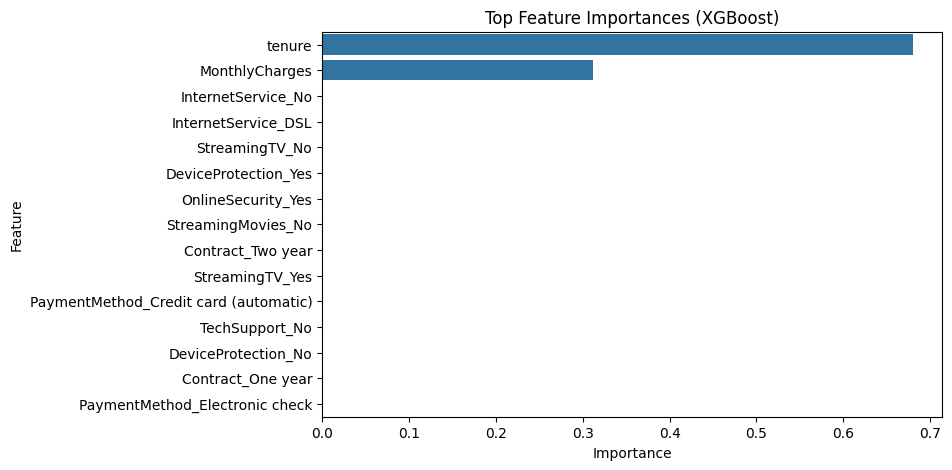

✅ XGBoost Revenue Model 저장 완료 (pipeline_customer_revenue_model.pkl)


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import cloudpickle   




# ---------------------------
# 1. 데이터 로드
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

y = df["TotalCharges"]

numeric_features = ["tenure", "MonthlyCharges", "SeniorCitizen"]
categorical_features = [
    "Contract", "PaymentMethod", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "PaperlessBilling", "Partner", "Dependents"
]

X = df[numeric_features + categorical_features]

# ---------------------------
# 2. 전처리 + Pipeline
# ---------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        objective="reg:squarederror"
    ))
])

# ---------------------------
# 3. 학습 & 평가
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# OHE된 feature 이름 추출
feature_names = (
    numeric_features +
    list(xgb_pipeline.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(categorical_features))
)

# Feature importance 값 가져오기
importances = xgb_pipeline.named_steps["model"].feature_importances_

# 정리
fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False).head(15)

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Top Feature Importances (XGBoost)")
plt.show()

# ---------------------------
# 4. 모델 저장 (pkl)
# ---------------------------
with open("pipeline_customer_revenue_model.pkl", "wb") as f:
    cloudpickle.dump(xgb_pipeline, f)

print("✅ XGBoost Revenue Model 저장 완료 (pipeline_customer_revenue_model.pkl)")


# 모델 성능
# XGBoost R²: 0.9986 → 99.9% 설명력, 거의 완벽에 가까움
# XGBoost RMSE: 84.5 → 고객 1명 매출 예측 오차가 평균 ±84 단위
# 고객 평균 매출이 수천 단위라면, 오차율은 3~5% 수준 → 실무적으로 매우 뛰어남

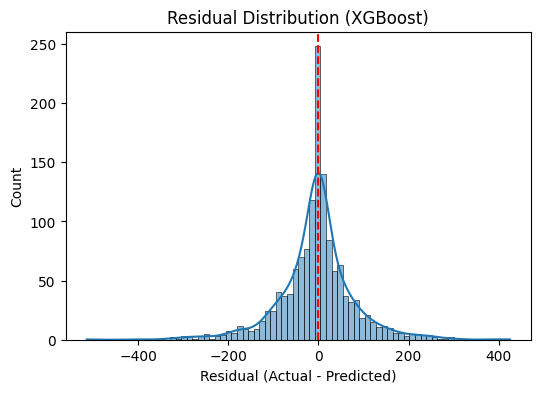

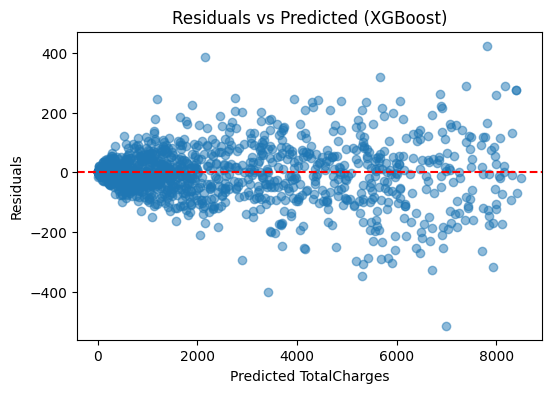

In [18]:
# 예측값
y_pred = xgb_pipeline.predict(X_test)

# Residual 계산
residuals = y_test - y_pred

# 분포 확인 (히스토그램)
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# 실제값 vs Residual (패턴 확인)
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted TotalCharges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (XGBoost)")
plt.show()


In [19]:
# importance 추출
importances = xgb_pipeline.named_steps["model"].feature_importances_

# feature 이름 매핑
feature_names = (
    numeric_features +
    list(xgb_pipeline.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(categorical_features))
)

fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False)

# top 20
fi.head(20)



,Feature,Importance
0,tenure,0.679615
1,MonthlyCharges,0.311774
12,InternetService_No,0.001253
10,InternetService_DSL,0.000881
25,StreamingTV_No,0.000356
21,DeviceProtection_Yes,0.000353
15,OnlineSecurity_Yes,0.000339
28,StreamingMovies_No,0.000323
5,Contract_Two year,0.000312
27,StreamingTV_Yes,0.000305


In [20]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    xgb_pipeline, X_test, y_test,
    n_repeats=10, random_state=42, scoring="r2"
)

perm_importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean
}).sort_values("Importance", ascending=False)

print(perm_importances.head(15))

# 2️⃣ Permutation Importance (스코어 감소 기반)

# scikit-learn의 permutation_importance 사용

# 특정 feature 값을 무작위로 섞어버렸을 때, 모델 성능(R², RMSE)이 얼마나 떨어지는지로 중요도를 측정


             Feature  Importance
0             tenure    1.253607
1     MonthlyCharges    0.640645
5    InternetService    0.000108
3           Contract    0.000037
10       StreamingTV    0.000025
4      PaymentMethod    0.000018
13           Partner    0.000015
6     OnlineSecurity    0.000011
2      SeniorCitizen    0.000008
14        Dependents    0.000008
8   DeviceProtection    0.000004
9        TechSupport    0.000002
12  PaperlessBilling    0.000002
7       OnlineBackup   -0.000004
11   StreamingMovies   -0.000015


In [21]:
# 지금 XGBoost 모델은 tenure + MonthlyCharges로 99% 이상 설명.

# 나머지 계약/서비스/결제 변수들은 “잔차(Residual)”를 조금씩 보정하는 미세 조정 역할.

# 결국, 본질은 기간 × 요금 구조지만, 고객 특성에 따라 약간의 차이를 추가 반영하고 있음.

#              Feature  Importance
# 0             tenure    1.253607
# 1     MonthlyCharges    0.640645
# 5    InternetService    0.000108
# 3           Contract    0.000037
# 10       StreamingTV    0.000025
# 4      PaymentMethod    0.000018
# 13           Partner    0.000015
# 6     OnlineSecurity    0.000011
# 2      SeniorCitizen    0.000008
# 14        Dependents    0.000008
# 8   DeviceProtection    0.000004
# 9        TechSupport    0.000002
# 12  PaperlessBilling    0.000002
# 7       OnlineBackup   -0.000004
# 11   StreamingMovies   -0.000015 

<!-- 지금 XGBoost 모델은 tenure + MonthlyCharges로 99% 이상 설명.

나머지 계약/서비스/결제 변수들은 “잔차(Residual)”를 조금씩 보정하는 미세 조정 역할.
             Feature  Importance
0             tenure    1.253607
1     MonthlyCharges    0.640645
5    InternetService    0.000108
3           Contract    0.000037
10       StreamingTV    0.000025
4      PaymentMethod    0.000018
13           Partner    0.000015
6     OnlineSecurity    0.000011
2      SeniorCitizen    0.000008
14        Dependents    0.000008
8   DeviceProtection    0.000004
9        TechSupport    0.000002
12  PaperlessBilling    0.000002
7       OnlineBackup   -0.000004
11   StreamingMovies   -0.000015

결국, 본질은 기간 × 요금 구조지만, 고객 특성에 따라 약간의 차이를 추가 반영하고 있음. -->

   <!-- [ Baseline ]
   ───────────────────────────────
   TotalCharges ≈ tenure × MonthlyCharges
   → 단순 계산식
   → 매출의 90% 설명 가능
   (비즈니스 로직 직관적)

            │
            ▼

   [ Residual 모델 ]
   ───────────────────────────────
   TotalCharges = Baseline + Residual
   Residual ≈ 계약/결제방식/서비스 등
   → RandomForest로 예측
   → Baseline으로 설명되지 않는 오차 보완

            │
            ▼

   [ Final: XGBoost 단일 모델 ]
   ───────────────────────────────
   TotalCharges ≈ f(tenure, MonthlyCharges, Contract, PaymentMethod, …)
   → 하나의 모델이 Baseline + Residual 관계를 동시에 학습
   → 성능: R² ≈ 0.999, RMSE ≈ 84
   → 해석:
        - tenure + MonthlyCharges: 99% 설명
        - 나머지 변수: 오차 보정 (잔차 설명) -->
